# RUL Time Prediction for Turbofan Engine

## 1. Explaining the data set

- Engine degradation simulation was carried out for run-to-failure using C-MAPSS (Commercial Modular Aero-Propulsion System Simulation). 
 
- Four different data sets simulated under different combinations of operational conditions and fault modes. 
 
- Records several sensor channels to characterize fault evolution.

- The data sets consists of multivariate time series signals.

- There are 100 engines are considered in data set FD001. Each of the engines is operating normally at the start of each time series and develops a fault at some point during the series. The fault grows in magnitude until the system failure. 

-  Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user.

- Each record in run-to-failure trajectories, which corresponds to a given operation cycle, is a 24-element vector, consists of three values for the operational settings and 21 values for engine performance measurements, which are contaminated with noise.

- All failures are caused by High-Pressure Compressor (HPC) degradation. 


![1](https://user-images.githubusercontent.com/44237325/73242153-25f63580-41b5-11ea-97b9-9b64dea3a09b.png)

In [9]:
# Importing libraries

import pandas as pd
import numpy as np
import random
from random import randint
import importlib
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
import colorsys
import itertools

In [2]:
#Loading the data set

columns = ['unit_nr', 'time', 'opset_1', 'opset_2', 'opset_3']
columns += ['sensor_{0:02d}'.format(s + 1) for s in range(21)]

df = pd.read_csv("train_FD001.txt", names = columns, delim_whitespace = True, header = None)
df_val = pd.read_csv("test_FD001.txt", names = columns, delim_whitespace = True, header = None)
RUL_1 = pd.read_csv("RUL_FD001.txt", names = ['RUL'], delim_whitespace = True, header = None)

In [3]:
df.columns

Index(['unit_nr', 'time', 'opset_1', 'opset_2', 'opset_3', 'sensor_01',
       'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06',
       'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16',
       'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21'],
      dtype='object')

## PCA
- This method allows us to reduce the number of variables correlated among themselves by selecting the basis vectors with higher variability for the original set. 
- In short, PCA finds the directions along which the data has maximum variability. 

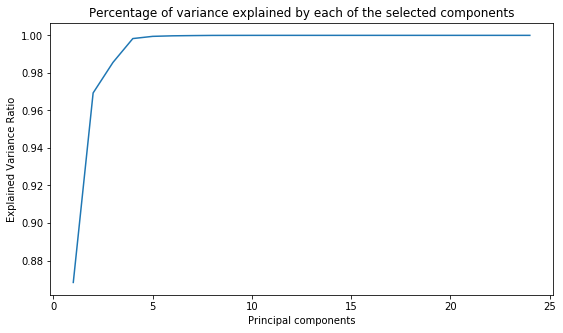

[0.868 0.101 0.016 0.013 0.001 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
1.0


In [12]:
# Viewing the variances of the components by using PCA - The first two-component having significant information about data

pca = PCA(n_components = 24, svd_solver = 'randomized',  whiten = True).fit(df.iloc[:,2:])
dimension = np.array(range(1,25))
variance = (pca.explained_variance_ratio_)
variance_cum = np.cumsum(variance)
plt.figure(figsize=(9, 5))
plt.plot(dimension,variance_cum)
plt.title('Percentage of variance explained by each of the selected components')
plt.xlabel('Principal components')
plt.ylabel('Explained Variance Ratio')
plt.show()
print(variance.round(3))
print(variance.sum().round(5))

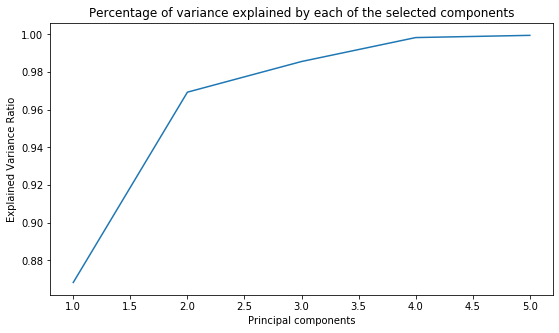

[0.87 0.1  0.02 0.01 0.  ]
0.99946


In [21]:
# Reduced the dimensions into only 5D-subspace - The two principal components have 96% variances in total. It is pretty good result

pca = PCA(n_components = 5, svd_solver = 'randomized',  whiten = True).fit(df.iloc[:,2:])
df_pca = pca.transform(df.iloc[:,2:])
pca_val= PCA(n_components = 5, svd_solver = 'randomized',  whiten = True).fit(df_val.iloc[:,2:])
df_val_pca = pca.transform(df_val.iloc[:,2:])
dimension = np.array(range(1,6))
variance = (pca.explained_variance_ratio_)
variance_cum = np.cumsum(variance)
plt.figure(figsize = (9, 5))
plt.plot(dimension,variance_cum)
plt.title('Percentage of variance explained by each of the selected components')
plt.xlabel('Principal components')
plt.ylabel('Explained Variance Ratio')
plt.show()
print(variance.round(2))
print(variance.sum().round(5))

In [23]:
df_pca = pd.DataFrame(df_pca, columns=['pc1','pc2','pc3','pc4','pc5'])
df_val_pca = pd.DataFrame(df_val_pca, columns=['pc1','pc2','pc3','pc4','pc5'])

In [27]:
df2 = pd.concat([df.loc[:,'unit_nr':'time'], df_pca], axis = 1 )
df2_val = pd.concat([df_val.loc[:,'unit_nr':'time'], df_val_pca], axis = 1)


In [30]:
# Creating new column for RUL time in training data

mapper = {}
for unit_nr in df['unit_nr'].unique():
    mapper[unit_nr] = df2['time'].loc[df2['unit_nr'] == unit_nr].max()
    
df2['RUL'] = df2['unit_nr'].apply(lambda nr: mapper[nr]) - df2['time']


mapper2 = {}
for unit_nr in df2_val['unit_nr'].unique():
    mapper[unit_nr] = df2_val['time'].loc[df2_val['unit_nr'] == unit_nr].max()
    
df2_val['RUL'] = df2_val['unit_nr'].apply(lambda nr: mapper[nr]) - df2_val['time']

In [31]:
df2.head()

,unit_nr,time,pc1,pc2,pc3,pc4,pc5,RUL
0,1,1,-0.637263,-0.733572,0.976613,2.023541,0.121910,191
1,1,2,-0.837781,-0.270051,1.123804,1.100069,0.538010,190
2,1,3,-0.575811,-0.389898,0.077715,-0.185389,2.495533,189
3,1,4,-0.670451,-0.842538,-0.751290,0.372257,0.158398,188
4,1,5,-0.509567,-0.429599,-1.315059,-0.461561,-0.325556,187


In [32]:
def healthindex(data, k):
    return(data.RUL[k] - data.RUL.min()) / float(data.RUL.max() - data.RUL.min())

In [33]:
HI_ = []
HI  = []

for i in range(df2['unit_nr'].min(), df['unit_nr'].max() + 1):
    data = df2[df.unit_nr == i]
    data = data.reset_index(drop = True)
    for k in range(len(data)):
        HI_ = healthindex(data, k)
        HI.append(HI_)
        
df2['HI'] = HI

In [34]:
df2.head()

,unit_nr,time,pc1,pc2,pc3,pc4,pc5,RUL,HI
0,1,1,-0.637263,-0.733572,0.976613,2.023541,0.121910,191,1.000000
1,1,2,-0.837781,-0.270051,1.123804,1.100069,0.538010,190,0.994764
2,1,3,-0.575811,-0.389898,0.077715,-0.185389,2.495533,189,0.989529
3,1,4,-0.670451,-0.842538,-0.751290,0.372257,0.158398,188,0.984293
4,1,5,-0.509567,-0.429599,-1.315059,-0.461561,-0.325556,187,0.979058


In [35]:
#linear regression 
m = ols('HI ~ pc1+pc2+pc3+pc4+pc5', df2).fit()
print (m.summary())

                            OLS Regression Results                            
Dep. Variable:                     HI   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     6452.
Date:                Tue, 28 Jan 2020   Prob (F-statistic):               0.00
Time:                        15:06:11   Log-Likelihood:                 5972.2
No. Observations:               20631   AIC:                        -1.193e+04
Df Residuals:                   20625   BIC:                        -1.188e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5000      0.001    396.389      0.0

In [36]:
# Fitting the Linear Regression Model obtained from training data on the test set.

df2_val['HI'] = m.predict(df2_val)
df2_val.head()

,unit_nr,time,pc1,pc2,pc3,pc4,pc5,RUL,HI
0,1,1,-0.841443,-0.841967,0.193937,-1.633091,-0.154577,30,0.751915
1,1,2,-0.419884,-1.220610,1.252204,0.412397,-1.052113,29,0.736271
2,1,3,-0.550266,-0.564600,0.138210,-1.756924,-0.485863,28,0.650693
3,1,4,-0.783009,-0.386382,-0.971108,1.215175,1.267508,27,0.723245
4,1,5,-0.884315,-0.570637,0.237424,0.470838,2.040650,26,0.798607


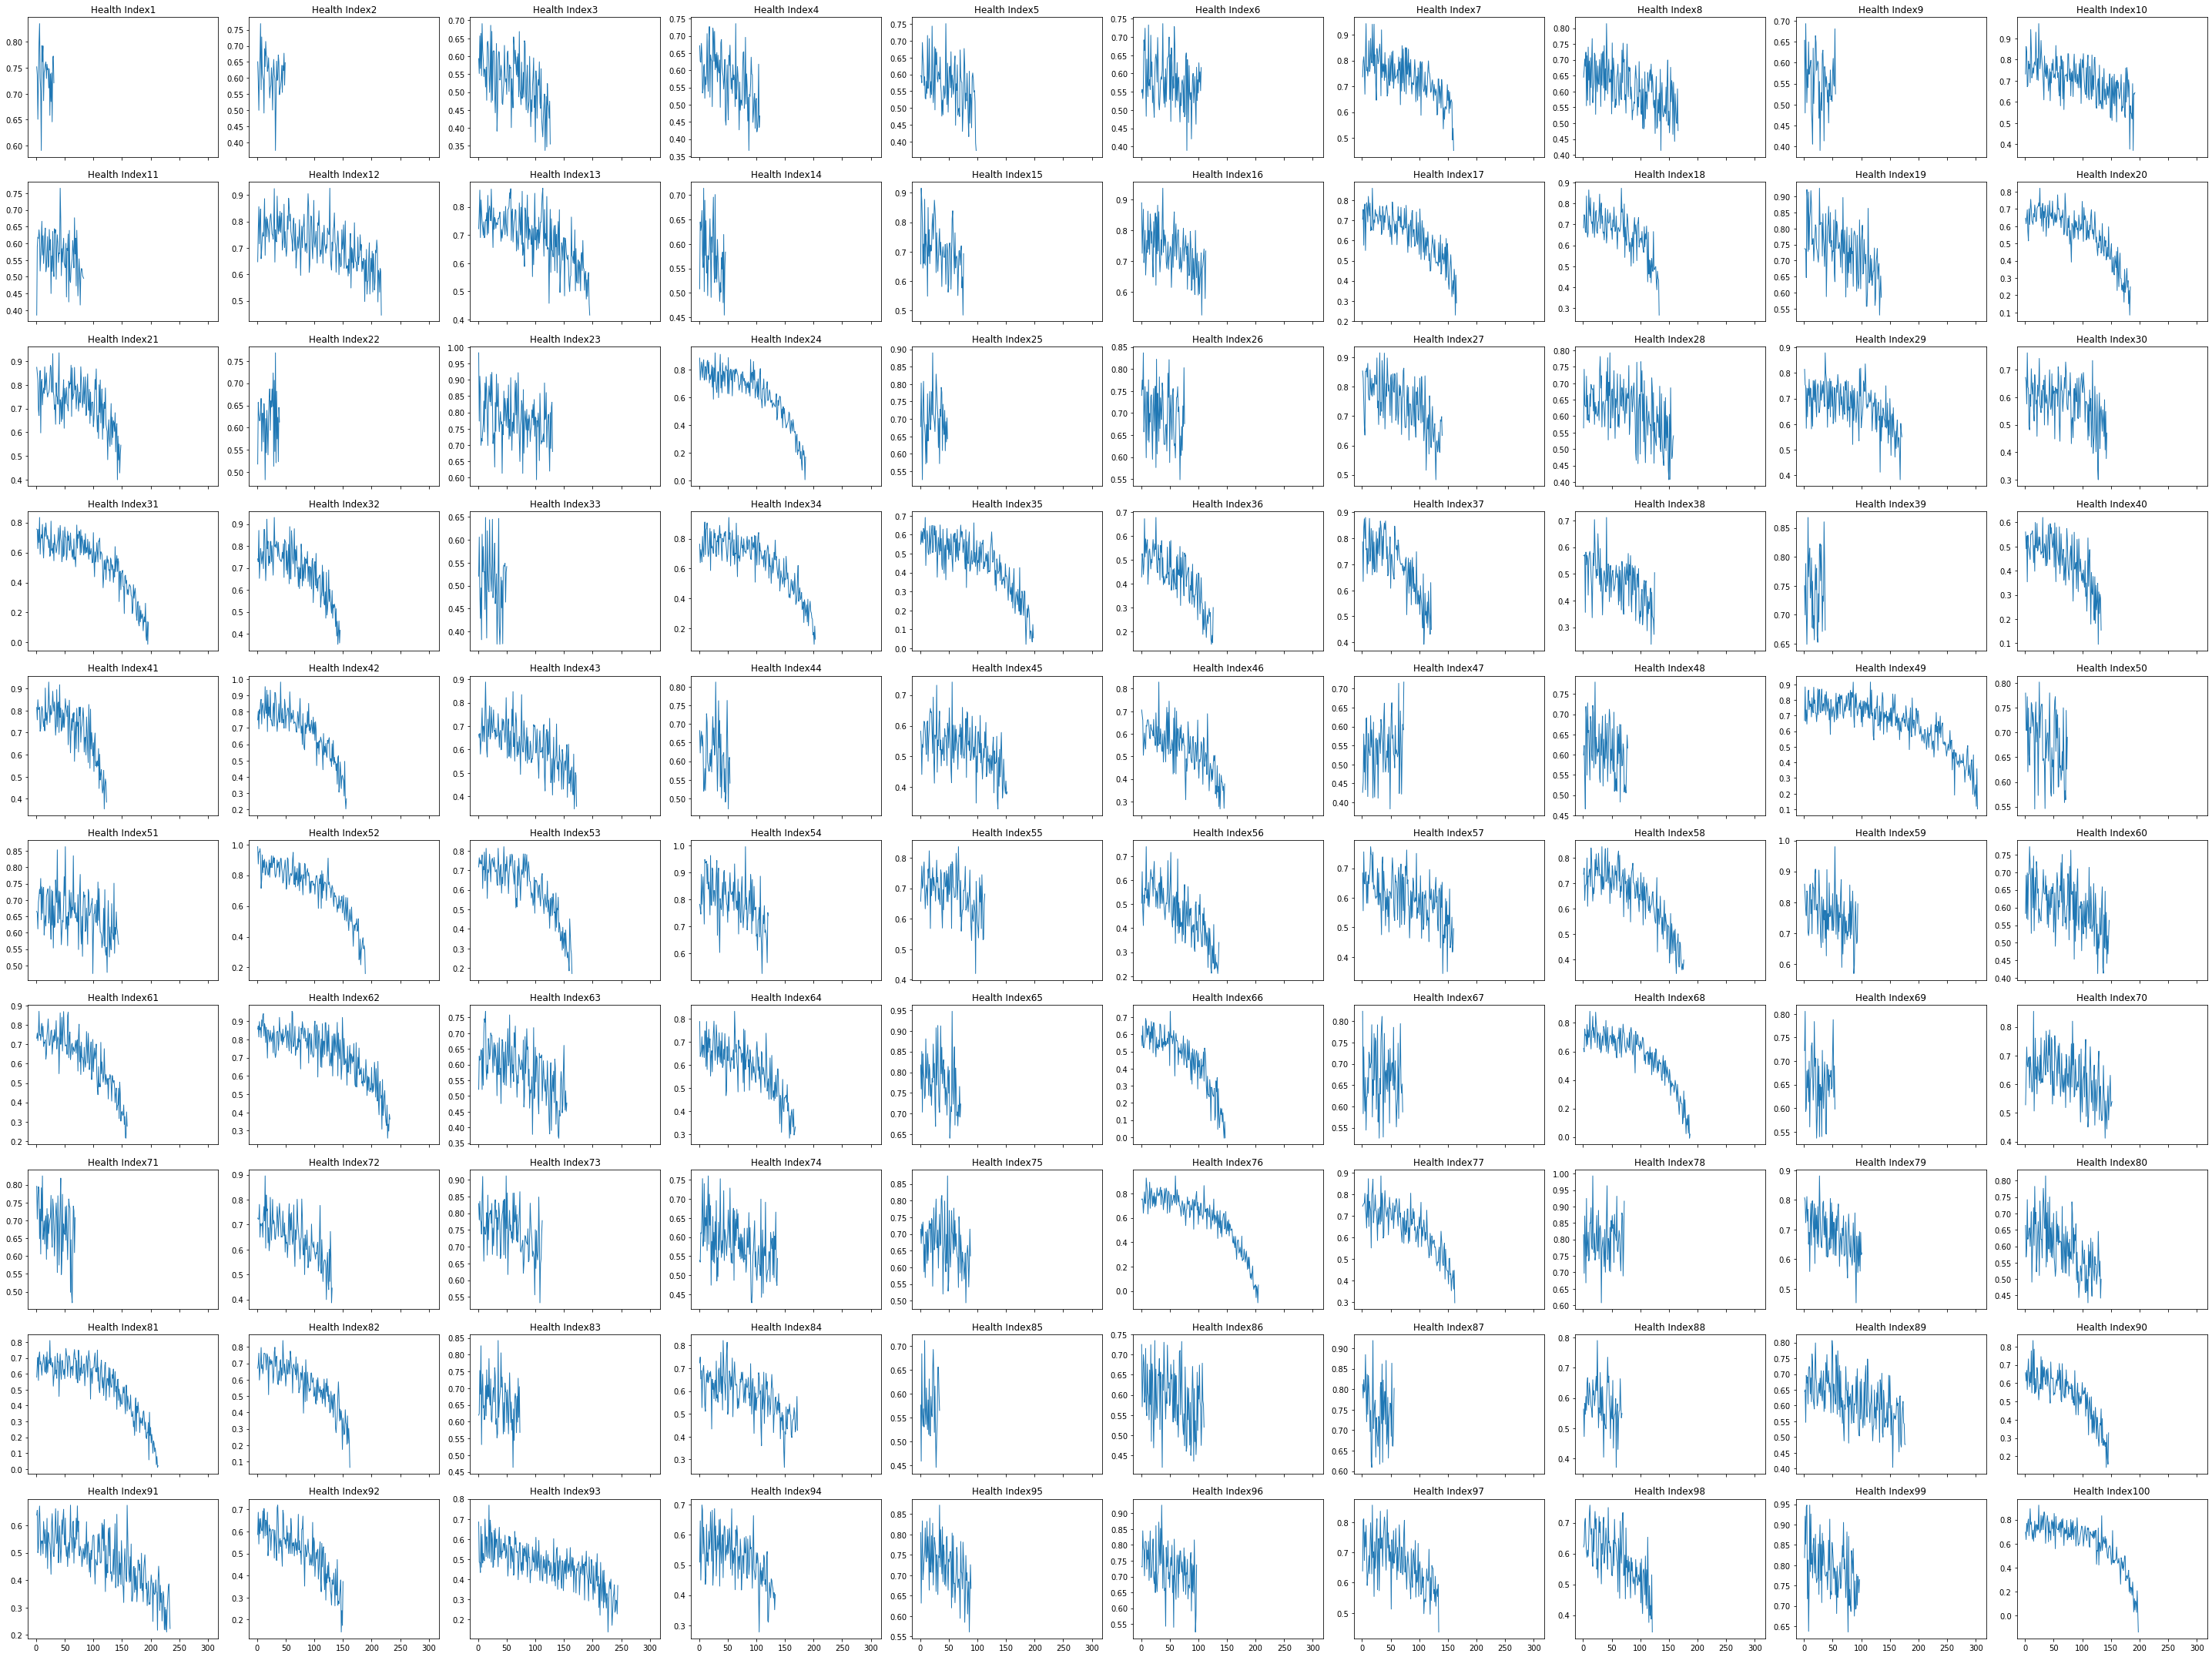

In [37]:
# Plotting health indexes of the test data for each engine

fig, ax = plt.subplots(10, 10, figsize = (40, 30), sharex = True)
c = 1

for i in range(0, 10):
    for j in range(0, 10):
        df_ = df2_val.query('unit_nr==' + str(c))
        ax[i,j].plot(df_['time'], df_.HI.values,linewidth = 1)
        ax[i,j].set_title('Health Index' + str(c))
        c += 1

plt.tight_layout()
plt.show()

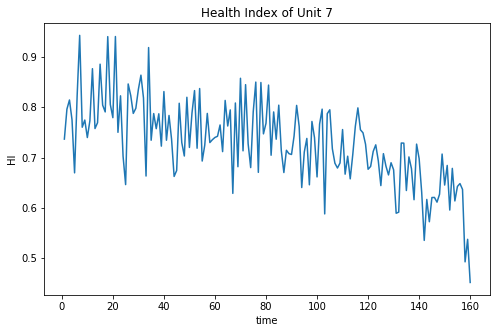

In [38]:
# Plotting health index of engine 7 
fig, ax = plt.subplots(1, 1, figsize = (8,5), sharex = True)
df_ = df2_val.query('unit_nr==7')
ax.plot(df_['time'], df_.HI.values )
ax.set_title('Health Index of Unit 7')
ax.set(xlabel = 'time', ylabel = 'HI')
plt.show()

### Smoothing the function of health index

In [39]:
# Defining a function for smoothing of health index

def hi_avg(df, un):
    temp_df = df.query('unit_nr=='+str(un))
    rolling = temp_df['HI'].rolling(window = 5)
    rolling_mean = rolling.mean()
    return rolling_mean

all_rolling_means = [hi_avg(df2_val, i) for i in range(1,101)]
df2_val = df2_val.assign(MA_HI = list(itertools.chain.from_iterable(all_rolling_means)))
df2_val.dropna(inplace=True)
df2_val.head()

,unit_nr,time,pc1,pc2,pc3,pc4,pc5,RUL,HI,MA_HI
4,1,5,-0.884315,-0.570637,0.237424,0.470838,2.040650,26,0.798607,0.732146
5,1,6,-0.802545,-1.439785,-0.792105,-1.641925,-0.691815,25,0.835263,0.748816
6,1,7,-0.585490,-0.582931,-1.000172,0.419426,1.233430,24,0.730952,0.747752
7,1,8,-0.764587,-0.810936,-1.120752,-1.985973,-0.947964,23,0.704590,0.758532
8,1,9,-0.631633,0.521007,0.317676,1.327413,2.600800,22,0.590478,0.731978


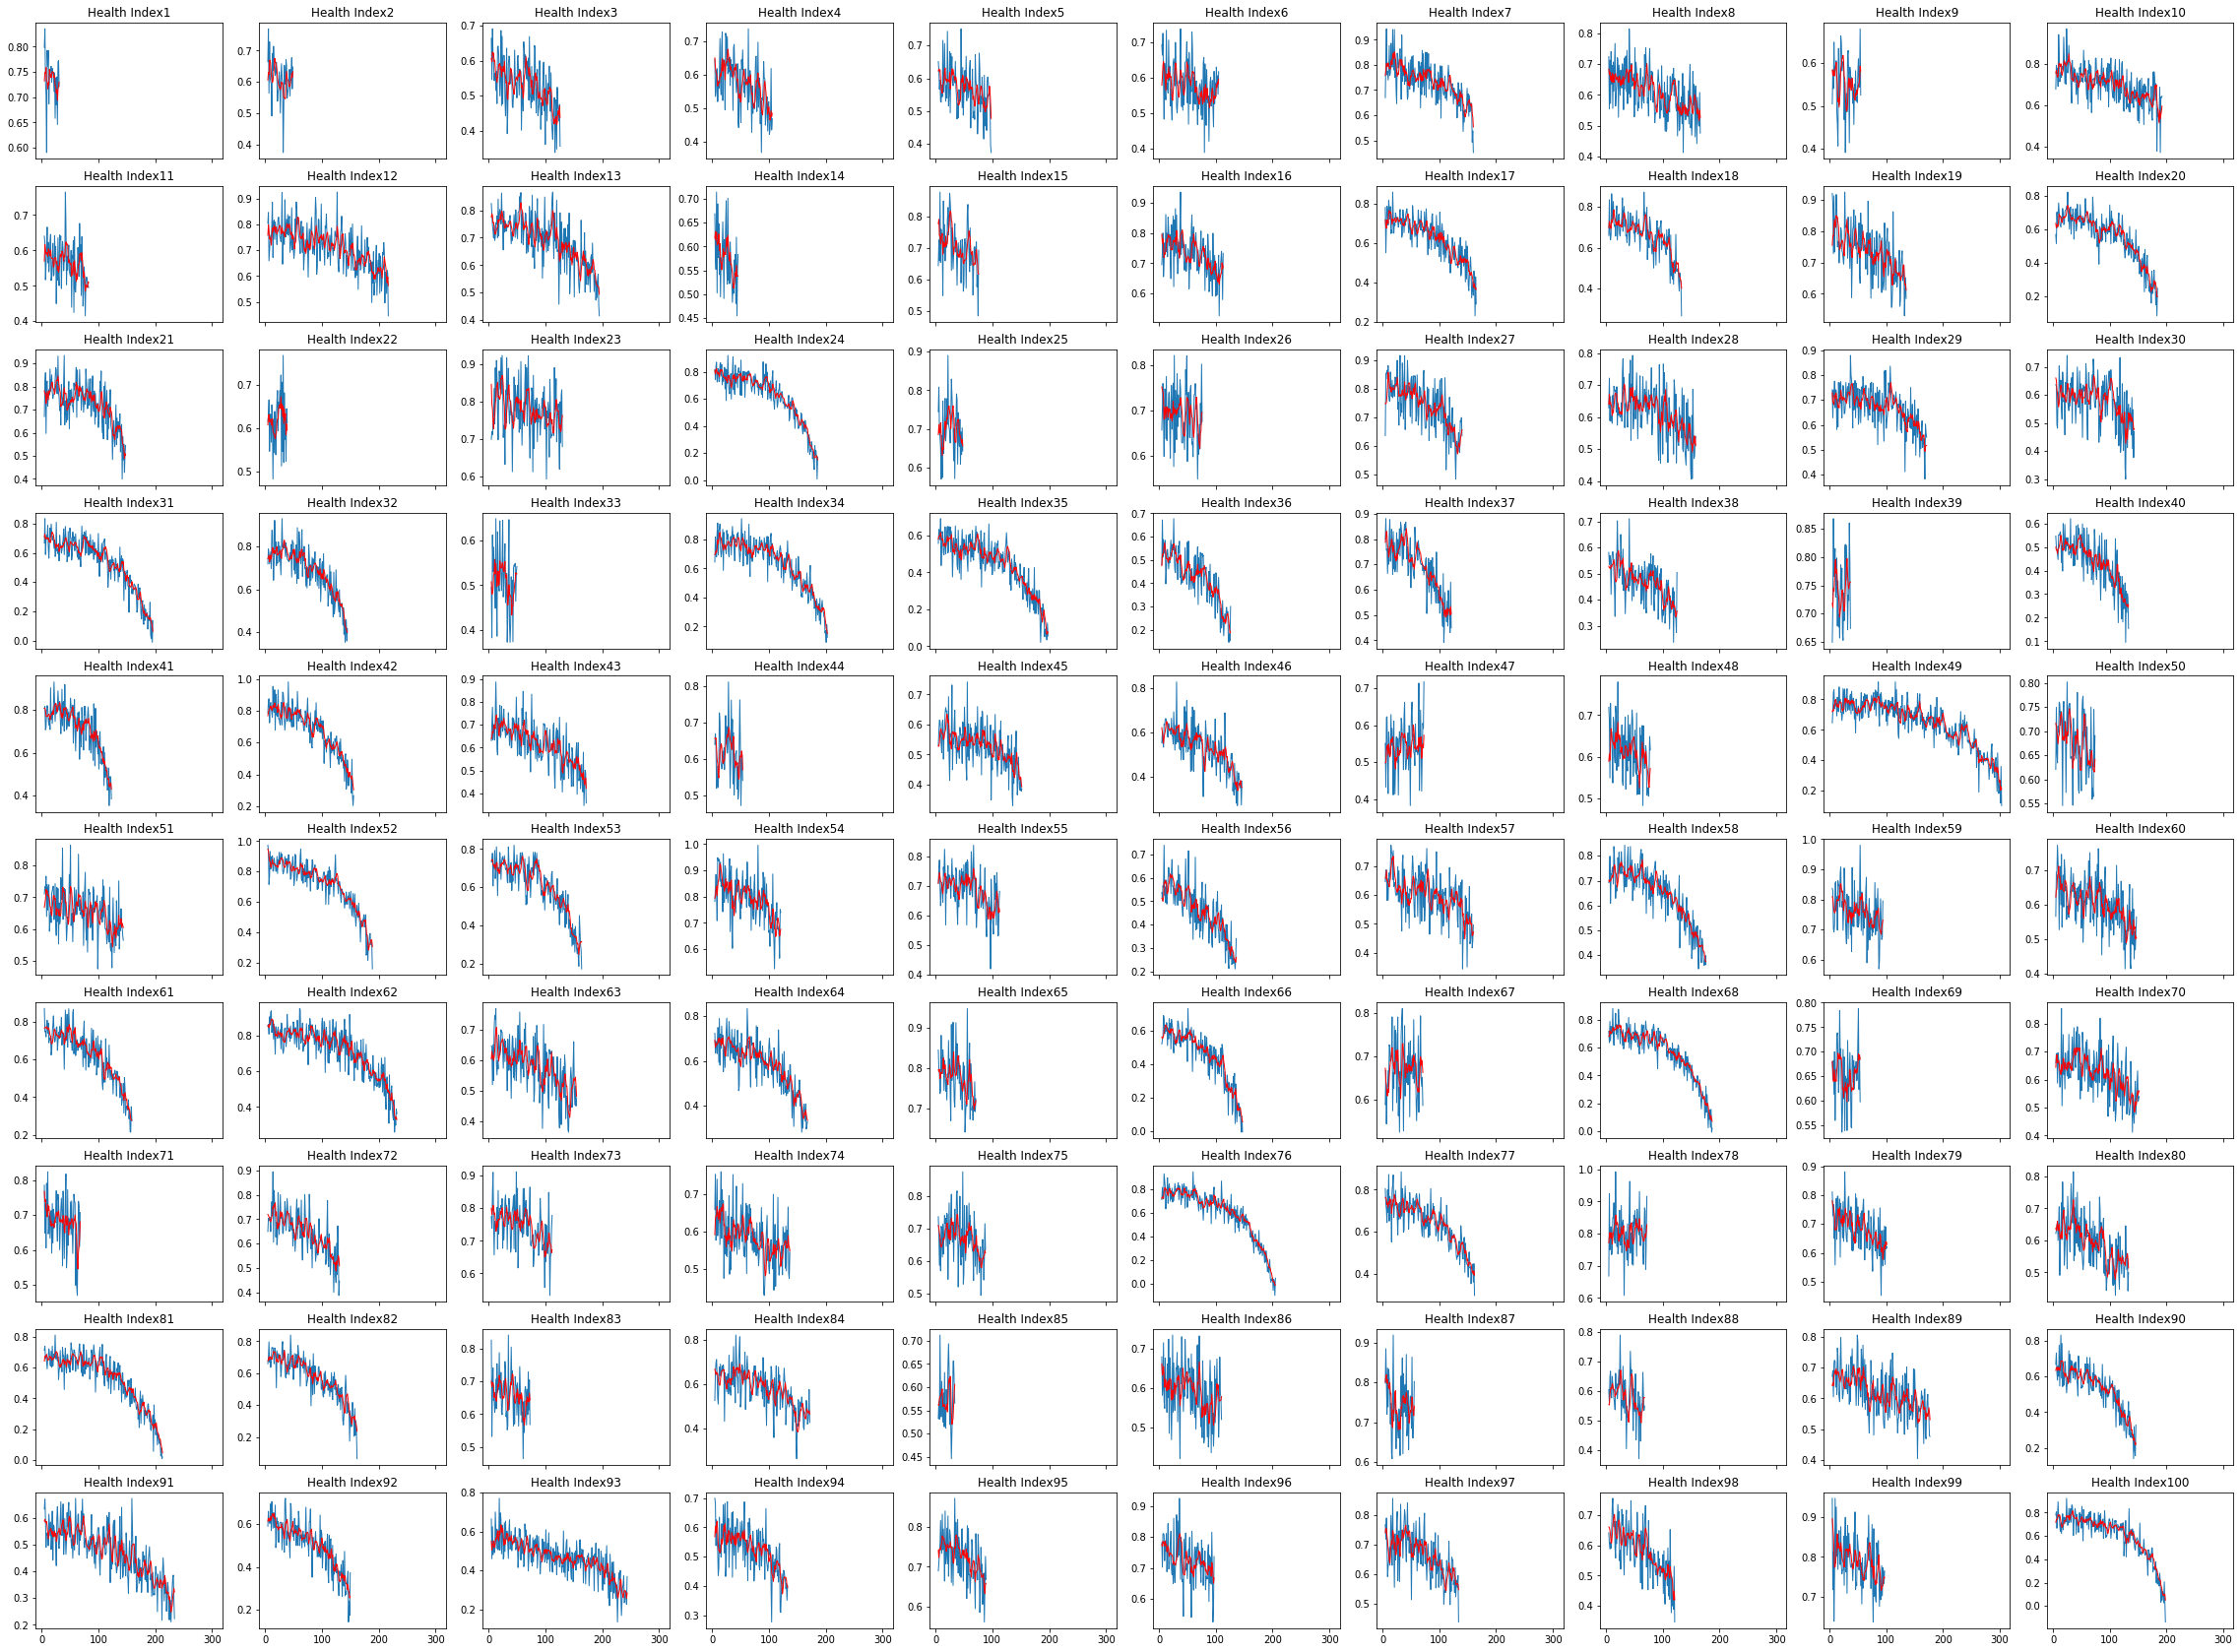

In [40]:
# Plotting health index after smoothing

fig,ax = plt.subplots(10, 10, figsize = (40,30), sharex = True)
c=1
for i in range(0,10):
    for j in range(0,10):
        df_ = df2_val.query('unit_nr=='+str(c))
        ax[i,j].plot(df_['time'], df_.HI.values, linewidth = 1)
        ax[i,j].plot(df_['time'], df_.MA_HI.values, linewidth = 1, color = 'r')
        ax[i,j].set_title('Health Index'+str(c))
        c+=1

Text(0.5, 1.0, 'Health Index')

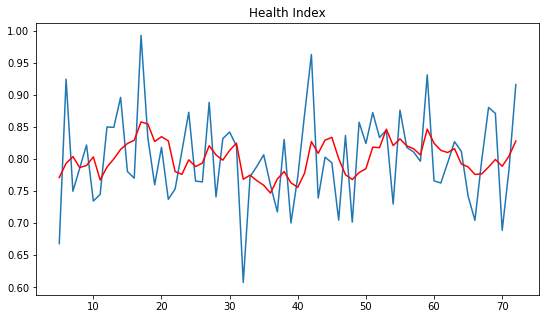

In [41]:
# Plotting health index for exact engine

fig, ax = plt.subplots(1, 1, figsize = (9,5),sharex = True)
df_ = df2_val.query('unit_nr==78')
ax.plot(df_['time'],df_.HI.values)
ax.plot(df_['time'],df_.MA_HI.values, color = 'r')
ax.set_title('Health Index')

### RUL Estimation

In [42]:
# Defining cost function

def scoring_function(error):
    if error>=0:
        s=np.exp(error/10)-1
        return s
    else:
        s=np.exp(-error/13)-1
        return s

In [43]:
#Converting the RUL_1's RUL column to a list

RUL = list(RUL_1['RUL'].values)

In [44]:
#Fitting the Polynomial to every engine

degrees    = range(6)
degree_fit = []
final_score=[]
estimated_rul_dict={}
roots_dict={}

for i in range(1,101):
    
    #Creating a sub-dataframe for every engine
    uniti = df2_val.query('unit_nr=='+str(i))
    
    score      = np.empty(len(degrees))
    
    estimated_rul_dict['unit_nr'+str(i)] = {}
    roots_dict['unit_nr'+str(i)] = {}
    
    for d in degrees:
        
        poly_params = np.polyfit(uniti['time'],uniti['MA_HI'],d)       #Fit data to the polynomial
        poly_       = np.poly1d(poly_params)                            #Construct the polynomial
        
        roots = poly_.r                                                 #Calculating roots of the polynomial
        roots = roots[np.isreal(roots)].real                            #Filtering out the real roots
        roots = roots[roots>0]                                          #Filtering out the positive roots
        
        if roots.shape[0]==1:
            pred_rul = roots - max(uniti['time'])                      #Calculating the remaining useful life
        
            errors = pred_rul - RUL[i-1] 
        
            score[d]=scoring_function(errors)
            
            estimated_rul_dict['unit_nr'+str(i)][scoring_function(errors).item()] = pred_rul.item()
            
            roots_dict['unit_nr'+str(i)][scoring_function(errors).item()] = roots.item()            
            
        elif roots.shape[0]>1:
            pred_rul = roots[0] - max(uniti['time'])
            
            errors = pred_rul - RUL[i-1]
            
            score[d]=scoring_function(errors)
            
            estimated_rul_dict['unit_nr'+str(i)][scoring_function(errors).item()] = pred_rul.item()
       
            roots_dict['unit_nr'+str(i)][scoring_function(errors).item()] = roots[0].item()
        
        else:
            score[d]=scoring_function(7000)
        
    
    degree_fit.append(np.argmin(score))
    final_score.append(np.min(score))

In [45]:
predicted_ruls = []
for i in estimated_rul_dict.keys():
    predicted_ruls.append(estimated_rul_dict[i][min(estimated_rul_dict[i].keys())])
    
roots_list=[]
for i in roots_dict.keys():
    roots_list.append(roots_dict[i][min(roots_dict[i].keys())])

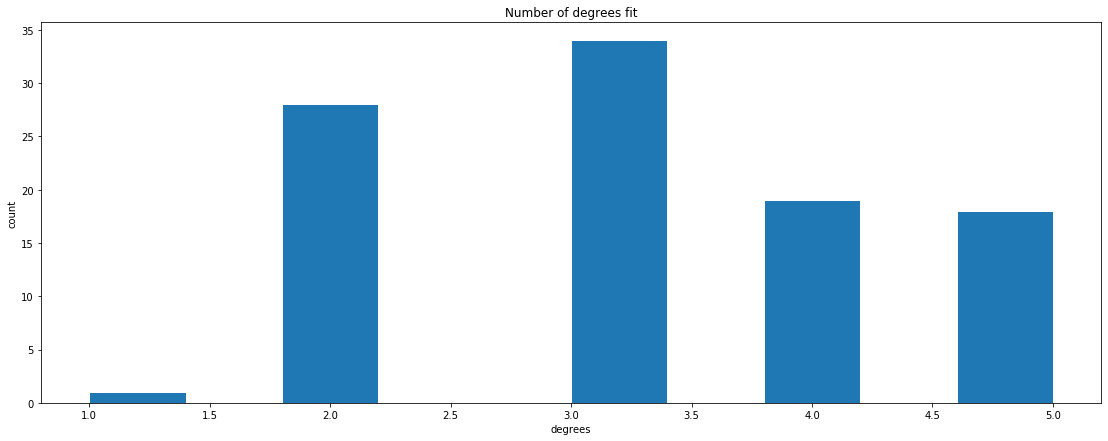

In [46]:
fig,ax=plt.subplots(1, 1, figsize = (19, 7))

ax.hist(degree_fit,edgecolor='white')
ax.set(xlabel='degrees',ylabel='count',title='Number of degrees fit')

plt.show()

In [47]:
#Creating a metric dataframe having engine number, the degree to which it was fit and its score

metric_poly = pd.DataFrame({'unit_nr':list(range(1,101)),'Degree':degree_fit,
                     'Score':final_score,'Predicted_RUL':predicted_ruls,'Actual_RUL':RUL,
                     'Polynomial_root':roots_list},
                    columns=['unit_nr','Degree','Score','Predicted_RUL','Actual_RUL',
                            'Polynomial_root'])
metric_poly

,unit_nr,Degree,Score,Predicted_RUL,Actual_RUL,Polynomial_root
0,1,2,2.007460e+01,72.375109,112,103.375109
1,2,4,1.358650e+02,34.053061,98,83.053061
2,3,3,4.508831e+00,46.817419,69,172.817419
3,4,2,3.536479e+01,117.936010,82,223.936010
4,5,2,4.276048e+05,220.659570,91,318.659570
5,6,1,4.876825e+33,868.698024,93,973.698024
6,7,3,1.253250e-01,89.465065,91,249.465065
7,8,5,2.869422e+01,50.917619,95,216.917619
8,9,5,3.097602e+22,628.875002,111,683.875002
9,10,3,2.137361e+02,149.694100,96,341.694100


In [48]:
metric_poly[metric_poly.Predicted_RUL<=30]

,unit_nr,Degree,Score,Predicted_RUL,Actual_RUL,Polynomial_root
14,15,4,70.058372,27.574478,83,103.574478
17,18,4,0.406213,23.568300,28,156.568300
19,20,4,0.139957,14.297120,16,198.297120
23,24,2,0.370445,23.151352,20,209.151352
30,31,3,0.084797,6.941889,8,202.941889
33,34,4,3.005660,20.877084,7,223.877084
34,35,5,0.090171,9.877649,11,207.877649
35,36,3,0.005883,19.058662,19,145.058662
39,40,4,0.787663,20.448177,28,153.448177
40,41,4,0.008209,17.893713,18,140.893713


In [49]:
metric_poly[metric_poly.Actual_RUL<=30]

,unit_nr,Degree,Score,Predicted_RUL,Actual_RUL,Polynomial_root
17,18,4,0.406213,23.568300,28,156.568300
19,20,4,0.139957,14.297120,16,198.297120
23,24,2,0.370445,23.151352,20,209.151352
30,31,3,0.084797,6.941889,8,202.941889
33,34,4,3.005660,20.877084,7,223.877084
34,35,5,0.090171,9.877649,11,207.877649
35,36,3,0.005883,19.058662,19,145.058662
36,37,2,56.222033,61.469390,21,182.469390
39,40,4,0.787663,20.448177,28,153.448177
40,41,4,0.008209,17.893713,18,140.893713


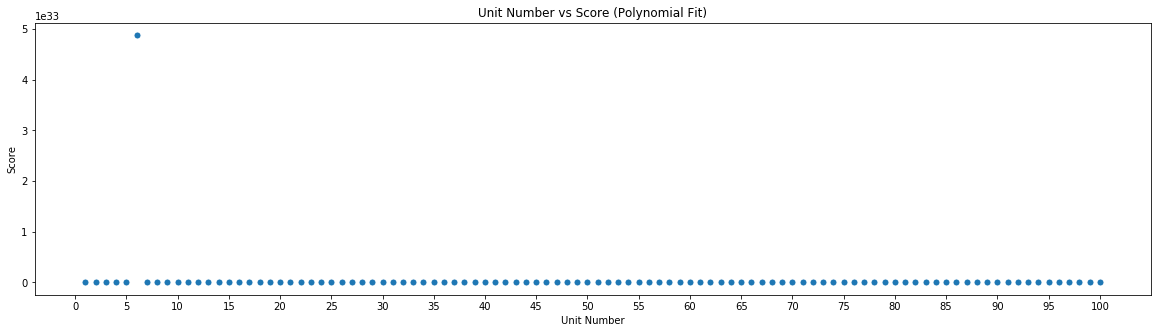

In [50]:
# Plotting score function

fig,ax = plt.subplots(1,1, figsize = (20,5))
ax.scatter(metric_poly.unit_nr, metric_poly.Score, edgecolor='white',  s=50)
ax.set_xticks(np.arange(0,105,5))
ax.set(xlabel='Unit Number',ylabel='Score',title='Unit Number vs Score (Polynomial Fit)')
plt.show()

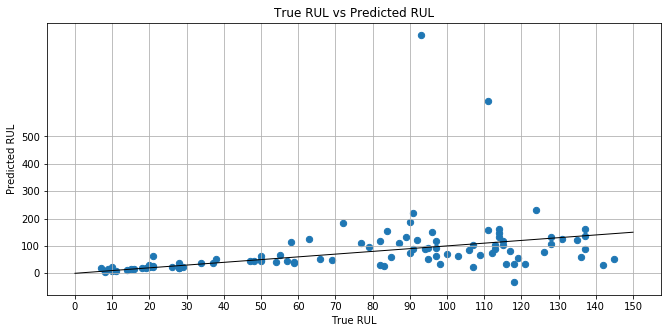

In [51]:
# Plotting actual vs predicted RUL

fig,ax=plt.subplots(1,1,figsize=(11,5))

ax.scatter(metric_poly.Actual_RUL,metric_poly.Predicted_RUL, s=40)
ax.grid()
ax.plot(np.arange(0,160,10),np.arange(0,160,10),c='black',linewidth=1)
ax.set(xlabel='True RUL',ylabel='Predicted RUL',title='True RUL vs Predicted RUL')
ax.set_xticks(np.arange(0,160,10))
ax.set_yticks(np.arange(0,600,100))
plt.show()

RUL is 7
The root at degree 0 is: []
Pred RUL at degree 1 d is: [156.39495934]
Error at degree 1 d is: [149.39495934]
Score at degree 1 d is: [3077092.17306826]
The root at degree 1 is: [359.39495934]
Pred RUL at degree 2 d is: [32.35473347]
Error at degree 2 d is: [25.35473347]
Score at degree 2 d is: [11.62240421]
The root at degree 2 is: [235.35473347]
Pred RUL at degree 3 d is: [22.98533604]
Error at degree 3 d is: [15.98533604]
Score at degree 3 d is: [3.94577464]
The root at degree 3 is: [225.98533604]
Pred RUL at degree 4 d is: [20.87708404]
Error at degree 4 d is: [13.87708404]
Score at degree 4 d is: [3.00566017]
The root at degree 4 is: [223.87708404]
Pred RUL at degree 5 d is: 76.34644077679116
Error at degree 5 d is: 69.34644077679116
Score at degree 5 d is: 1026.2535644769803
The root at degree 5 is: [279.34644078 234.5128207 ]


Text(0.5, 1.0, 'Health Index')

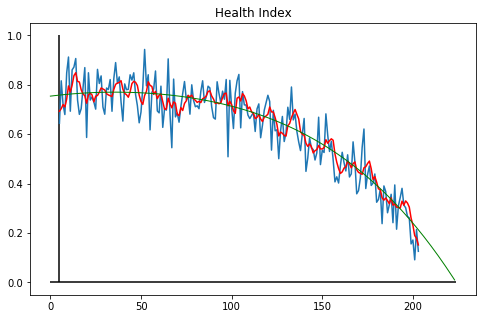

In [53]:
u = 34
unit3 = df2_val.query('unit_nr=='+str(u))
print('RUL is '+ str(RUL[u-1]))
rul_dict={}
for i in range(6):
    poly_params = np.polyfit(unit3['time'], unit3['MA_HI'],i)   #Fit the data to the polynomial
    poly_1_test = np.poly1d(poly_params)                             #Consruct the polynomial

    roots = poly_1_test.r
    roots
    roots = roots[np.isreal(roots)].real
    roots = roots[roots>0]
    
    if roots.shape[0]==1:
            pred_rul = roots - max(unit3['time'])                      #Calculating the remaining useful life
        
            er = pred_rul - RUL[u-1] 
        
            sc = scoring_function(er)
            
            rul_dict[sc.item()] = pred_rul
            print('Pred RUL at degree ' +str(i)+' d is:',pred_rul)
            print('Error at degree ' +str(i)+' d is:',er)
            print('Score at degree '+str(i)+' d is:',sc)
    elif roots.shape[0]>1:
            pred_rul = roots[0] - max(unit3['time'])                      #Calculating the remaining useful life
        
            er = pred_rul - RUL[u-1] 
        
            sc = scoring_function(er)
            
            rul_dict[sc.item()] = pred_rul
            print('Pred RUL at degree ' +str(i)+' d is:',pred_rul)
            print('Error at degree ' +str(i)+' d is:',er)
            print('Score at degree '+str(i)+' d is:',sc)
        
    print('The root at degree '+str(i)+' is:',roots)

fig,ax=plt.subplots(1,1,figsize = (8,5),sharex = True)
ax.plot(unit3['time'], unit3.HI.values)
ax.plot(unit3['time'], unit3.MA_HI.values,color = 'r')

poly_params_test = np.polyfit(unit3['time'], unit3['MA_HI'], metric_poly.Degree[u-1])   #Fit the data to the polynomial
poly_1_test_2 = np.poly1d(poly_params_test)

xPoly = np.arange(0,metric_poly.Polynomial_root.iloc[u-1])                # Generate 100 x-coordinates from 0 to max(x)
yPoly = poly_1_test_2(xPoly)

ax.plot(np.arange(0, metric_poly.Polynomial_root.iloc[u-1]), yPoly, linewidth = 1,color = 'g')

ax.vlines(min(unit3['time']), 0, 1)
ax.hlines(0,0,metric_poly.Polynomial_root.iloc[u-1])
ax.set_title('Health Index')

In [ ]:
# Plotting the polynomial fit

fig,ax = plt.subplots(10,10,figsize = (40,30))
c = 1
for i in range(0,10):
    for j in range(0,10):
        
        df_u1 = df2_val.query('unit_nr=='+str(c))
        ax[i,j].plot(df_u1['time'],df_u1.HI.values,linewidth = 1)
        ax[i,j].plot(df_u1['time'],df_u1.MA_HI.values,linewidth = 1,color = 'r')
        
        #Fitting the polynomial
        poly_params = np.polyfit(df_u1['time'], df_u1['MA_HI'], metric_poly.Degree[c-1])   #Fit the data to the polynomial
        poly_1 = np.poly1d(poly_params)                             #Consruct the polynomial
        
        xPoly = np.arange(0,metric_poly.Polynomial_root.iloc[c-1])                # Generate 100 x-coordinates from 0 to max(x)
        yPoly = poly_1(xPoly)                    # Use the polynomial to calculate the y-coordinates
        
        #Plotting the Polynomial
        ax[i,j].plot(np.arange(0,metric_poly.Polynomial_root.iloc[c-1]),yPoly,linewidth = 2,color = 'g')
        ax[i,j].set_title('Health Index'+str(c))
        
        ax[i,j].vlines(min(df_u1['time']),0,1)
        ax[i,j].hlines(0,0,metric_poly.Polynomial_root.iloc[c-1])
        c += 1
        
plt.tight_layout()